In [1]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

//anaconda3/envs/zendesk/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
matplotlib.rcParams.update({'font.size': 15})

In [4]:
%matplotlib notebook

**Resources**

Andreas Mueller Github: https://amueller.github.io/ml-workshop-2-of-4/slides/02-cross-validation-grid-search.html#24  
Elements of Statistical Learning, Chapter 7

### Find usable data

Examine time windows of parsed (usable) data by channel, inquiry type

In [5]:
# query_zdt='''
# select inquiry_type, via_channel,
#        date_trunc('month', created_at) as month,
#        count(*)
# from zendesk_tickets
# group by  1,2,3;
# '''
df = pd.read_clipboard(sep=',')

In [76]:
df.head()

inquiry_type via_channel      month  ntickets
0  about_attune        chat 2018-02-01         2
1  about_attune        chat 2018-03-01         1
2  about_attune        chat 2018-04-01         4
3  about_attune        chat 2018-05-01        16
4  about_attune        chat 2018-06-01        11

In [44]:
df.rename(columns={'count':'ntickets'}, inplace=True)

In [25]:
df['month'] = pd.to_datetime(df.month)

Nulls

In [100]:
df[df.inquiry_type.isnull()].groupby('month')['ntickets'].sum()

month
2018-02-01       1
2018-03-01      16
2018-04-01      35
2018-05-01       9
2018-06-01       2
2018-07-01       2
2018-08-01       1
2018-09-01       1
2018-11-01       1
2019-02-01       2
2019-06-01     114
2019-07-01     583
2019-08-01     927
2019-09-01     807
2019-10-01     743
2019-11-01     981
2019-12-01     897
2020-01-01    1029
2020-02-01    1270
2020-03-01    1566
2020-04-01     376
Name: ntickets, dtype: int64

In [103]:
df[df.inquiry_type.isnull()]['ntickets'].sum()/df['ntickets'].sum()

0.03833132049208851

4% nulls, remove

In [105]:
dfn = df[~df.inquiry_type.isnull()].copy()

In [115]:
df.groupby('inquiry_type').sum()['ntickets'].sort_values(ascending=False)

inquiry_type
billing_inquiries                  32042
quote_changes                      29733
endorsements                       22992
workers_compensation               20371
eligibility                        20057
cancellations                      19284
wc                                 14343
renewals                           13095
miscellaneous_na                   11873
technical_support                   7526
general_inquiries                   6350
document_requested                  5865
about_attune                        5027
underwriting_audit                  4942
voicemails                          4341
policy_issuance_                    4214
wc_inquiry                          3180
loss_runs                           3014
document_requests                   1833
bind_requests                       1538
claim_inquiries                      678
commission_inquiries                 611
coverage_inquiries                   532
coverage_inquiries_                  353
rei

Merge names

In [170]:
it = [[('about_attune', 'general_inquiries', 'general_inquiry', 'miscellaneous_na', 'technical_support',
        'voicemails', 'commission_inquiries', 'binding_moratorium', 'intuit_support', 'claim_inquiries'), 'general'],
      [('coverage_inquiries', 'coverage_inquiries_', 'eligibility'), 'eligibility'],
      [('bind_requests', 'policy_issuance', 'policy_issuance_'), 'issuance'],
      [('endorsement_non_premium_bearing', 'endorsements'), 'policy_change'],
      [('agent_cancellation', 'cancellations'), 'cancellation'],
      [('renewal_indication', 'renewals'), 'renewal'],
      [('billing_inquiries', 'collections'), 'billing'],
      [('loss_runs', 'document_requests', 'document_requested'), 'documents'],
      [('workers_compensation', 'wc', 'wc_inquiry'), 'wc'],
      [('reinstatement_request',), 'reinstatement_request'],
      [('quote_changes',), 'quote_changes'],
      [('underwriting_audit',), 'underwriting_audit']]

In [171]:
# it[0] for m in it
dlist = [{i: m[1]} for m in it for i in m[0]]
result = {}
for d in dlist:
    result.update(d)

In [172]:
df['it_bucket'] = df.inquiry_type.map(lambda x: result.get(x));
dfn['it_bucket'] = dfn.inquiry_type.map(lambda x: result.get(x))

Since 1/2019

In [173]:
dfn[dfn.it_bucket.isnull()].groupby('inquiry_type').sum()

ntickets
inquiry_type                            
agency_management__commissions       200
agency_management__logging_in          6
agency_management__user_access         4
attune_apartments                     15
broker_of_record                       1

In [174]:
dfn[dfn.month > '2019-01-01'].groupby('it_bucket').sum()['ntickets'].sort_values(ascending=False)

it_bucket
wc                       33044
general                  29228
billing                  24963
quote_changes            19510
policy_change            17880
cancellation             15328
eligibility              14672
renewal                  11518
documents                 8171
issuance                  3490
underwriting_audit        3397
reinstatement_request      338
Name: ntickets, dtype: int64

Plot over time

In [ ]:
#unstack for plotting
df.groupby(['month','inquiry_type']).sum()['ntickets'].reset_index()

In [178]:
dfn[dfn.month > '2019-01-01'].groupby(['month','it_bucket']).sum()['ntickets'].reset_index().head(10)

month           it_bucket  ntickets
0 2019-02-01             billing      1351
1 2019-02-01        cancellation       805
2 2019-02-01           documents       457
3 2019-02-01         eligibility       823
4 2019-02-01             general      1104
5 2019-02-01            issuance       208
6 2019-02-01       policy_change       734
7 2019-02-01       quote_changes      1441
8 2019-02-01             renewal       346
9 2019-02-01  underwriting_audit       410

<IPython.core.display.Javascript object>


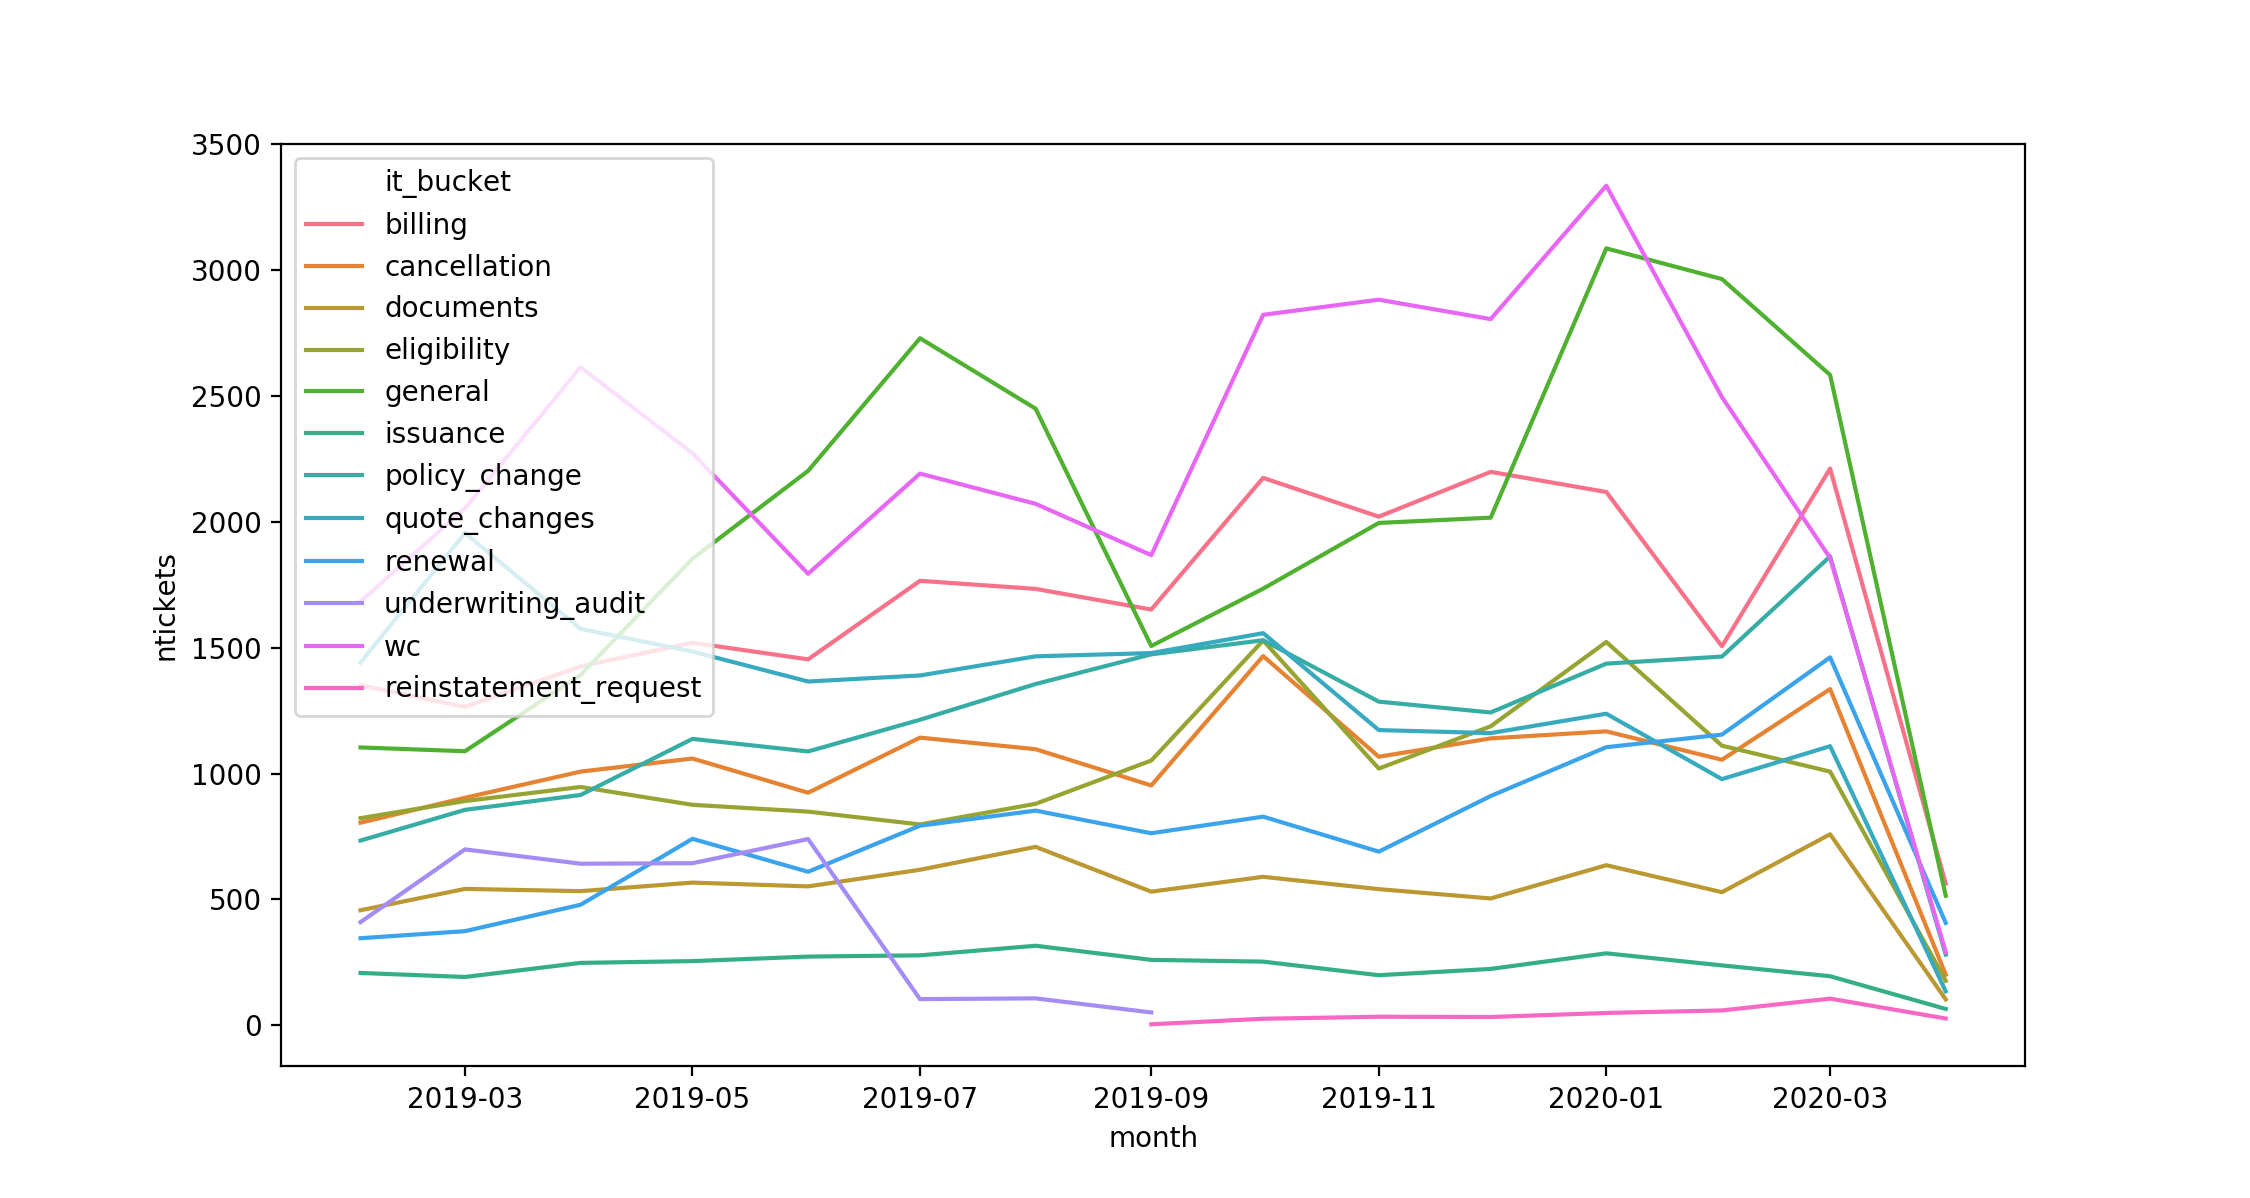

In [182]:
#timeseries, multiple, seaborn
fig,ax = plt.subplots(figsize=(10,6))

data = dfn[dfn.month > '2019-01-01'].groupby(['month','it_bucket']).sum()['ntickets'].reset_index()

sns.lineplot(x="month", y="ntickets",
             hue="it_bucket",
             data=data,
             ax=ax)

By channel

In [193]:
dfn[dfn.month > '2019-01-01'].groupby(['it_bucket', 'via_channel'])[
    'ntickets'].sum().reset_index().sort_values(by=['it_bucket','ntickets'], ascending=False)

it_bucket via_channel  ntickets
56                     wc       email     16553
58                     wc         web     12997
55                     wc        chat      2143
57                     wc       voice       932
54                     wc         api       419
49     underwriting_audit         api      2585
53     underwriting_audit         web       573
51     underwriting_audit       email       195
52     underwriting_audit       voice        27
50     underwriting_audit        chat        17
48                renewal         web     10419
46                renewal       email       686
45                renewal        chat       263
47                renewal       voice       144
44                renewal         api         6
41  reinstatement_request       email       175
42  reinstatement_request       voice        69
40  reinstatement_request        chat        47
43  reinstatement_request         web        47
36          quote_changes        chat     11402
37          quote_changes       email      5251
38          quote_changes       voice      1664
39          quote_changes         web      1167
35          quote_changes         api        26
32          policy_change       email     12828
34          policy_change         web      2175
31          policy_change        chat      1819
33          policy_change       voice       796
30          policy_change         api       262
27               issuance       email      2911
26               issuance        chat       300
29               issuance         web       182
28               issuance       voice        79
25               issuance         api        18
21                general        chat     10364
23                general       voice      9433
22                general       email      7263
24                general         web      1358
20                general         api       810
16            eligibility        chat     10350
17            eligibility       email      2052
18            eligibility       voice      1593
19            eligibility         web       670
15            eligibility         api         7
12              documents       email      3307
11              documents        chat      1636
14              documents         web      1623
13              documents       voice      1603
10              documents         api         2
9            cancellation         web      9952
7            cancellation       email      3897
8            cancellation       voice       923
6            cancellation        chat       515
5            cancellation         api        41
3                 billing       voice     11263
2                 billing       email      8055
1                 billing        chat      3725
4                 billing         web      1882
0                 billing         api        38

Need emails and web!

### Get data

Set up connection

In [8]:
from sqlalchemy import create_engine
import os

attune_dw_host = os.getenv("ATTUNE_DW_HOST")
attune_dw_user = os.getenv("ATTUNE_DW_USER")
attune_dw_db = os.getenv("ATTUNE_DW_DB", "attune_dw")
port = "5432"


class Connection:
    def __init__(self):
        pass

    def dw_engine(self):
        connection_string = (
            f"postgresql://{attune_dw_user}@{attune_dw_host}:{port}/{attune_dw_db}"
        )
        return create_engine(connection_string)

In [9]:
conn = Connection().dw_engine()

Get CCC names

In [10]:
query = """
    select distinct(assignee_name) assignee_name
    from zendesk_tickets
    where assignee_name is not null;
    """

In [11]:
names_df = pd.read_sql_query(query, con=conn)

In [12]:
names_df.head()

assignee_name
0    Brian Holst
1     Jazzmin L.
2      Sharon L.
3       David R.
4  Madison Black

Parsed data (billings chats)

In [13]:
query=r'''
select
    a.ticket_id
     ,z.inquiry_type
     ,z.tags
     ,jsonb_array_elements(parsed)->>'author_type' as author_type
     ,jsonb_array_elements(parsed)->>'text' as text
     ,jsonb_array_elements(parsed)->>'timestamp' as timestamp
from amitt_tickets_parsed a
         left join zendesk_tickets z on a.ticket_id = z.ticket_id
where is_valid_chat=True
  and a.created_at >= '2020-01-01'
  and a.created_at <= '2020-03-01'
  and z.inquiry_type in ('billing_inquiries','collections');
'''

In [14]:
df = pd.read_sql(query,con=conn)

In [15]:
def interaction_number(grp):
    s = grp.sort_values(by='timestamp', ascending=True)
    b_label = 0; c_label = 0;
    cnt_id = {'broker':b_label, 'ccc': c_label}
    label_list = []
    prev_author_type = ''
    for i in range(len(s)):
        author_type = s['author_type'].iloc[i]
        if author_type!=prev_author_type:
            cnt_id[author_type]+=1            
        label_list.append(cnt_id[author_type])
        prev_author_type = author_type    
    return label_list

In [16]:
df_new = df.astype({'ticket_id':int}).sort_values(['ticket_id','timestamp']).reset_index(drop=True)

In [17]:
df_new

ticket_id       inquiry_type  \
0        196950  billing_inquiries   
1        196950  billing_inquiries   
2        196950  billing_inquiries   
3        196950  billing_inquiries   
4        196950  billing_inquiries   
...         ...                ...   
6146     228508  billing_inquiries   
6147     228508  billing_inquiries   
6148     228508  billing_inquiries   
6149     228508  billing_inquiries   
6150     228508  billing_inquiries   

                                                   tags author_type  \
0     [attune_insurance, billing_inquiries, updaed_i...      broker   
1     [attune_insurance, billing_inquiries, updaed_i...         ccc   
2     [attune_insurance, billing_inquiries, updaed_i...         ccc   
3     [attune_insurance, billing_inquiries, updaed_i...         ccc   
4     [attune_insurance, billing_inquiries, updaed_i...         ccc   
...                                                 ...         ...   
6146  [attune_insurance, billing_center_instructions...         ccc   
6147  [attune_insurance, billing_center_instructions...         ccc   
6148  [attune_insurance, billing_center_instructions...      broker   
6149  [attune_insurance, billing_center_instructions...         ccc   
6150  [attune_insurance, billing_center_instructions...      broker   

                                                   text            timestamp  
0     Please have the email address changed for invo...  2020-01-02 14:33:39  
1                                  Happy New Year Myrna  2020-01-02 14:34:10  
2                                     One moment please  2020-01-02 14:34:15  
3     Would you like to keep mike@mavrealty.com on f...  2020-01-02 14:35:06  
4     I've updated accounting@mavrealty.com to this ...  2020-01-02 14:37:13  
...                                                 ...                  ...  
6146                                           Hi Maria  2020-02-28 19:54:19  
6147  I'm not sure I understand your question, can y...  2020-02-28 19:55:49  
6148  the insured left the payment with the agent so...  2020-02-28 19:59:44  
6149                  Do you have access to our portal?  2020-02-28 20:00:12  
6150                    yes, I do, but I am the broker.  2020-02-28 20:03:59  

[6151 rows x 6 columns]

In [18]:
inum = pd.DataFrame(df_new.groupby('ticket_id', sort=False).apply(
    interaction_number).explode(), columns=['interaction_number']).reset_index().rename(columns={'ticket_id':'ticket_id_y'})

In [19]:
df_int = pd.concat([df_new,inum], axis=1)

In [20]:
all(df_int.ticket_id==df_int.ticket_id_y)

True

In [21]:
df_int.drop('ticket_id_y', inplace=True, axis=1)

Distribution of chat round trips, billings 2020/1-3

In [22]:
df_int.groupby('ticket_id')['interaction_number'].nunique().value_counts()

4     85
5     61
3     61
1     45
2     42
6     38
7     28
8     24
9     11
12     6
10     5
13     4
11     4
15     2
26     1
17     1
Name: interaction_number, dtype: int64

In [23]:
import operator

In [24]:
def auth_int_filter_concat(df, author_type, interaction_number, ifilter_cumulative=True):
    def ifc(ifilter_cumulative):
        return operator.le if ifilter_cumulative else operator.eq
    
    comparison = ifc(ifilter_cumulative)
    filt = df[(df['author_type'] == author_type) & (
        comparison(df['interaction_number'], interaction_number))]
    return filt.groupby('ticket_id')['text'].agg(lambda x: ' '.join(x))

Distrubtion of Num Lines for the first broker interaction

In [25]:
df_int[(df_int['author_type'] == 'broker') & (df_int['interaction_number']
                                              <= 2)].groupby('ticket_id').count()['text'].value_counts()

2     200
3     100
4      50
5      26
1      19
6      13
8       4
7       4
15      1
9       1
Name: text, dtype: int64

In [26]:
df_int[df_int.ticket_id==196950].head(2)

ticket_id       inquiry_type  \
0     196950  billing_inquiries   
1     196950  billing_inquiries   

                                                tags author_type  \
0  [attune_insurance, billing_inquiries, updaed_i...      broker   
1  [attune_insurance, billing_inquiries, updaed_i...         ccc   

                                                text            timestamp  \
0  Please have the email address changed for invo...  2020-01-02 14:33:39   
1                               Happy New Year Myrna  2020-01-02 14:34:10   

  interaction_number  
0                  1  
1                  1

In [412]:
filtered_data = auth_int_filter_concat(df_int,'broker',2).reset_index()
ccc_labels_df = df_int.groupby('ticket_id')[['inquiry_type','tags']].first().reset_index()
data_df = filtered_data.merge(ccc_labels_df, on='ticket_id', validate="one_to_one")

In [537]:
data_df.head(2)

ticket_id                                               text  \
0     196950  Please have the email address changed for invo...   
1     196970  The quote screen is showing Employee Dishonest...   

        inquiry_type                                               tags  
0  billing_inquiries  [attune_insurance, billing_inquiries, updaed_i...  
1  billing_inquiries  [attune_insurance, billing_inquiries, broker_o...

In [538]:
data_df.to_pickle('billings_sample')

### Preprocess, Vectorize
- doc embeddings
- embedding done once and stored

get stopwords

In [33]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

In [34]:
nltk_stopwords = set(stopwords.words('english'))

In [35]:
len(nltk_stopwords)
len(ENGLISH_STOP_WORDS)

179

318

In [36]:
def get_custom_chat_stopwords():

    """Returns custom list of stop words for chat data
    """

    greetings = [
        "hi",
        "good",
        "hey",
        "hello",
        "thank",
        "thanks",
        "morning",
        "afternoon",
        "evening",
        "please",
        "ok",
        "okay",
        "great",
        "welcome",
        "day",
        "today",
        "would",
        "yes",
        "amp",
        "consider",
        "quick",
        "question",
        "nope",
        "thx",
        "ty",
        "add",
        "try",
        "maybe",
        "instead",
    ]
    insurance = ["attune", "blackboard", "risk", "bop", "quote", "market"]

    stop_words = greetings
    stop_words.extend(insurance)

    return stop_words

def make_ccc_agent_first_names_set(agent_names):
    """Takes list of unique assignee names from zendesk ticket data and returns 
    list of first names, lowered for used in stopwords."""

    return set([n.split()[0].lower() for n in agent_names])

In [37]:
ccc_names = make_ccc_agent_first_names_set(names_df.assignee_name.values)
stop_words = nltk_stopwords.union(get_custom_chat_stopwords()).union(ccc_names)

In [498]:
import unicodedata

def normalise(text):
    """ Normalise (normalize) unicode data in Python to remove umlauts, accents etc. """
    return unicodedata.normalize('NFKD', text).encode('utf-8')

In [39]:
import string

In [40]:
table = str.maketrans('', '', string.punctuation)
stop_words = [i.translate(table) for i in stop_words]

TFIDF

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
tfidf = TfidfVectorizer(
    input='content',
    decode_error='strict',
    strip_accents='unicode',
    lowercase=True,
#     preprocessor=None,
#     tokenizer=None,
    analyzer='word',
    stop_words=stop_words,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 1),
    max_df=0.9,
    min_df=0.05,
#     max_features=1000,
)

In [416]:
tfv = tfidf.fit_transform(data_df['text'].values)

In [417]:
tfv.sum(axis=0)

matrix([[36.4941039 , 13.97493571, 40.2076538 , 34.76239645, 12.22597063,
         18.84282837, 10.26348272, 17.08934166, 14.03582105, 13.7573546 ,
         15.41698737, 13.9477489 ,  9.85111244, 13.81105982, 21.5208171 ,
         17.94097333, 15.28500004, 17.7125493 , 35.09447069, 31.68309351,
         14.42418085, 14.26341752, 17.0867723 , 13.67003042, 10.40212337,
         16.51111536, 22.08307989, 14.02841977, 16.77522598, 26.15949121,
         56.21353734, 18.92171575, 15.45232775, 48.1826376 , 13.20435162,
         16.73509185, 11.2488726 , 13.58611422, 15.24757217,  8.57887585,
         16.85163587]])

In [935]:
# tfidf.get_feature_names()

- Output of TFIDF Vectorizer is a an (m-samples X n-feature weights) 
- Extract top features per sample/document by sorting along feature axis (column index is feature index, value is weight)

### Dimensionality Reduction

LDA

In [45]:
from sklearn.decomposition import LatentDirichletAllocation

In [418]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=10, max_iter=10, random_state=0, 
                                learning_method='online',verbose=True)

In [419]:
lda_out = lda.fit_transform(tfv)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [446]:
lda_df = pd.DataFrame(get_top_topics_per_doc(lda_out, top_n=1))

In [447]:
lda_df.head(2)

top_topic_inds  top_topic_weights
0               1           0.693959
1               5           0.549973

In [441]:
display_df.head(2)

ticket_id                                               text  \
0     196950  Please have the email address changed for invo...   
1     196970  The quote screen is showing Employee Dishonest...   

        inquiry_type                                               tags  \
0  billing_inquiries  [attune_insurance, billing_inquiries, updaed_i...   
1  billing_inquiries  [attune_insurance, billing_inquiries, broker_o...   

        x_10       y_10      x_30       y_30       x_55      y_55  
0 -55.828384  -7.762603  5.888761 -29.193521   7.393922  9.699470  
1 -42.626999 -33.584007 -5.405331   9.821214 -10.420538 -1.346664

In [449]:
display_df = pd.concat([display_df, lda_df['top_topic_inds']], axis=1)

In [450]:
display_df.head(2)

ticket_id                                               text  \
0     196950  Please have the email address changed for invo...   
1     196970  The quote screen is showing Employee Dishonest...   

        inquiry_type                                               tags  \
0  billing_inquiries  [attune_insurance, billing_inquiries, updaed_i...   
1  billing_inquiries  [attune_insurance, billing_inquiries, broker_o...   

        x_10       y_10      x_30       y_30       x_55      y_55  \
0 -55.828384  -7.762603  5.888761 -29.193521   7.393922  9.699470   
1 -42.626999 -33.584007 -5.405331   9.821214 -10.420538 -1.346664   

   top_topic_inds  
0               1  
1               5

In [473]:
kpt = get_top_keywords_per_topic(tfidf, lda, top_n=5)

In [487]:
keyword_topic_df = pd.DataFrame(kpt).apply(lambda x: ' - '.join(x), axis=1)

In [488]:
keyword_topic_df.head(2)

0          pay - auto - set - policy - billing
1    invoice - email - com - insured - account
dtype: object

In [467]:
get_topic_coverage_stats(lda_out, top_n=3)

{'weight_hist_by_topic_N': array([[249, 159,  10,   0],
        [ 69, 247, 102,   0],
        [ 39, 125, 254,   0]]),
 'weight_hist_by_topic_N_pct': array([[0.59569378, 0.38038278, 0.02392344, 0.        ],
        [0.16507177, 0.59090909, 0.24401914, 0.        ],
        [0.09330144, 0.29904306, 0.6076555 , 0.        ]])}

t-SNE

Resources:  
https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0  
https://distill.pub/2016/misread-tsne/

In [961]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler,StandardScaler
scaler = MaxAbsScaler()

In [420]:
tfv.shape

(418, 41)

In [963]:
data_scaled = scaler.fit_transform(tfv)

In [968]:
tfv.sum(axis=0)

matrix([[32.08339841, 12.90572152, 37.8698993 , 36.21754969, 12.46621718,
         15.77902275, 19.2413996 , 13.39223605, 12.83748624, 13.07111699,
         13.16853812, 19.45132431, 14.20857011, 13.97114839, 32.72929826,
         27.15156631, 14.76207345, 16.41614906, 11.83417994, 14.29543071,
         19.89603054, 12.34791965, 15.48728993, 21.91776916, 55.09440078,
         17.20194123, 15.34048595, 39.76495213, 12.57319779, 12.78800828,
         14.61406744]])

In [967]:
data_scaled.sum(axis=0)

matrix([[32.08339841, 12.90572152, 37.8698993 , 36.21754969, 15.77213134,
         18.46100224, 19.2413996 , 15.45162064, 14.73984831, 15.53690636,
         13.16853812, 19.45132431, 14.20857011, 13.97114839, 32.72929826,
         27.15156631, 18.24671169, 16.41614906, 13.52036161, 16.49370361,
         22.62290634, 14.27062542, 16.74498229, 21.91776916, 55.09440078,
         17.20194123, 15.96294517, 39.76495213, 14.3646777 , 15.46130951,
         17.66910178]])

In [48]:
from sklearn.manifold import TSNE
import time

In [49]:
def get_tsne_embeddings(vectorized_data):
    """
    Perform t-SNE embeddings for different perplexity levels.
    
    Args:
        vectorized_data (numpy sparse matrix): m samples x n features, 
            from vectorizer.fit_transform() output

    Returns:
        out_dict (dict of numpy matrix): 
            m samples x n_components (embedding dimension)

    """
    perplexities = [10, 30, 55]
    out_dict = {}
    for p in perplexities:
        tsne = TSNE(n_components=2, verbose=1, n_iter=3000, perplexity=p)
        print('-'*10)
        print(f'PERPLEXITY: {p}')
        time_start = time.time()
        tsne_results = tsne.fit_transform(vectorized_data.toarray())
        print(f'DONE! Time elapsed: {time.time()-time_start} seconds')
        out_dict.update({str(p):tsne_results})
    return out_dict

In [421]:
tsne_results = get_tsne_embeddings(tfv)

----------
PERPLEXITY: 10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 418 samples in 0.003s...
[t-SNE] Computed neighbors for 418 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 418 / 418
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.855675
[t-SNE] KL divergence after 3000 iterations: 1.154991
DONE! Time elapsed: 4.803450107574463 seconds
----------
PERPLEXITY: 30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 418 samples in 0.000s...
[t-SNE] Computed neighbors for 418 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 418 / 418
[t-SNE] Mean sigma: 0.398737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.683136
[t-SNE] KL divergence after 2600 iterations: 1.202585
DONE! Time elapsed: 4.040176868438721 seconds
----------
PERPLEXITY: 55
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 418 samples in 0.001s...
[t-SNE] Computed n

Add tSNE results to display dataframe

In [422]:
tsne_dfs = pd.concat([pd.DataFrame(data,
                                  columns=['_'.join([i, col_suffix])
                                           for i in ['x', 'y']]
                                  ) for col_suffix, data in tsne_results.items()
                     ],
                    axis=1)

In [423]:
display_df = pd.concat([data_df, tsne_dfs], axis=1)

In [424]:
display_df.head(2)

ticket_id                                               text  \
0     196950  Please have the email address changed for invo...   
1     196970  The quote screen is showing Employee Dishonest...   

        inquiry_type                                               tags  \
0  billing_inquiries  [attune_insurance, billing_inquiries, updaed_i...   
1  billing_inquiries  [attune_insurance, billing_inquiries, broker_o...   

        x_10       y_10      x_30       y_30       x_55      y_55  
0 -55.828384  -7.762603  5.888761 -29.193521   7.393922  9.699470  
1 -42.626999 -33.584007 -5.405331   9.821214 -10.420538 -1.346664

### Inspection Tools

In [460]:

def get_top_keywords_per_topic(fit_vectorizer, trained_model, top_n=3):
    """
    Get top_n keywords per topic by finding indices of higest weighted features,
    then decoding those features back to tokens using the vectorizer.

    Args:
        fit_vectorizer (sklearn vectorizer): after executing vectorizer.fit()
        trained_model (sklearn model): after executing model.fit()

    Returns:
        top_keywords_per_topic(numpy matrix): t topics x top_n keywords

    """
    feature_tokens = fit_vectorizer.get_feature_names()
    top_keywords_per_topic = np.apply_along_axis(lambda x: [feature_tokens[i] for i in x],
                                                 axis=1,
                                                 arr=np.fliplr(np.argsort(trained_model.components_, axis=1))[:, :top_n])
    return top_keywords_per_topic

def get_top_topics_per_doc(model_output, top_n=3):
    """Get top_n n topics and weights per document from data transformed by LDA topic model.
    
    Args:
        model_output (numpy matrix): m samples x n topic weights, 
            from lda model .transform() output
        top_n (int, optional): num topics per document. Defaults to 3.

    Returns:
        top_topic_inds (numpy matrix): m samples x top_n (topic number)
        top_topic_weights (numpy matrix): m samples x top_n (topic weight)
    """

    top_topic_inds = np.fliplr(np.argsort(model_output, axis=1))[:, :top_n].squeeze()
    top_topic_weights = np.fliplr(np.sort(model_output, axis=1))[:, :top_n].squeeze()
    
    return {'top_topic_inds':top_topic_inds, 'top_topic_weights':top_topic_weights}

def topic_weight_histogram(topic_weights_per_doc):
    """
    Given an array of size (m x 1), where m is the number of samples/docs 
    and the array values are topic weights for a particular topic number,
    output a histogram of the number of docs per bin.

    """
    arr = topic_weights_per_doc.round(1).squeeze()
    bins = [0, 0.7, 0.8, 0.9, 1]
    docs_per_bin, _ = np.histogram(arr, bins=bins)
    return docs_per_bin

def get_topic_coverage_stats(model_output, top_n=3):
    """
    Restrict model output to top n topics of interest, take cumulative sum 
    to find the total weight covered by the 1st, 1st and 2nd, ... sum(1-Nth) topic weights per doc.

    Args:
        model_output (numpy matrix): m samples x n topic weights, 
            from lda model .transform() output

    Returns:
        top_n_tfidf_features(numpy matrix): m samples x n feature tokens
        top_n_tfidf_weights (numpy matrix): m samples x n feature weights

    """

    # this is a matrix of size (N top topics x n_bin_edges), values are sample counts per bin
    weight_hist_by_topic_N = np.apply_along_axis(topic_weight_histogram,
                                                 axis=0,
                                                 arr=np.fliplr(np.sort(model_output, axis=1)).cumsum(axis=1)[:, :top_n]).T

    pct = weight_hist_by_topic_N / \
        weight_hist_by_topic_N.sum(axis=1, keepdims=True)
    return {'weight_hist_by_topic_N': weight_hist_by_topic_N,
            'weight_hist_by_topic_N_pct': pct}

### Clustering

K-means

In [ ]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)

for k in K:
    time_start = time.time()
    km = KMeans(n_clusters=k, random_state=0, n_init=30, max_iter=400)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    print('kmeans {} done! Time elapsed: {} seconds'.format(k,time.time()-time_start))

for k in [3,4,5]:
    km = KMeans(n_clusters=k, random_state=0, n_init=30, max_iter=400)
    klabels = km.fit_predict(data_transformed)
    fdf['k'+str(k)] = klabels

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Visualize

Static tSNE

In [1011]:
import seaborn as sns

In [ ]:
# sns.scatterplot(
#     x="x", y="y",
#     hue="inquiry_type",
# #     palette=sns.color_palette("hls", 3),
#     data=display_df,
#     legend="full",
#     alpha=0.3
# )

In [ ]:
plt.figure(figsize=(16,7))

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="k3",
    palette=sns.color_palette("hls", 3),
    data=fdf,
    legend="full",
    alpha=0.3
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="k4",
    palette=sns.color_palette("hls", 4),
    data=fdf,
    legend="full",
    alpha=0.3
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="k5",
    palette=sns.color_palette("hls", 5),
    data=fdf,
    legend="full",
    alpha=0.3
)

#### bokeh

In [5]:
# Standard imports 
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [6]:
from bokeh.models import (Button, ColumnDataSource, CustomJS, DataTable,
                          NumberFormatter, RangeSlider, TableColumn,Select)
from bokeh.layouts import column, row
from bokeh.plotting import figure
from bokeh.palettes import Spectral5, Dark2_6,Category10_10

Examples
- [download CSV example](https://github.com/bokeh/bokeh/tree/master/examples/app/export_csv)
- [clustering app example](https://github.com/bokeh/bokeh/tree/master/examples/app/clustering)

In [7]:
Spectral5

('#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c')

Data
- retrieve data from dw, including ticket_id, inquiry_type, and tags for labeling viz.
- add interaction number to chats (another table perhaps)
- filter by author type and interaction number 
- prepare final data_df

Preprocess & Vectorize  
Fit Model  
Visualize

In [8]:
display_df.head(2)

NameError: name 'display_df' is not defined

In [58]:
def camel_to_title(camel_case_text):
    return " ".join([s.capitalize() for s in camel_case_text.split('_')])

Interaction Tools

In [209]:
def get_selection_tags(display_df):    
    vc = display_df.tags.explode().value_counts()
    df = pd.DataFrame(vc).reset_index().rename(columns={'index':'tag','tags':'count'})
    fractions = vc/display_df.tags.size
    df['frac'] = fractions.values
    df['name'] = df.apply(lambda x: ' - '.join([x['tag'],str(x['count']),str(x['frac'])]), axis=1)
    return df[(df.frac>=.02) & (df.frac<=0.75)].sort_values('frac', ascending=False)

In [211]:
get_selection_tags(display_df).head()

tag  count      frac  \
4                   billing_process     80  0.191388   
5              payment_confirmation     62  0.148325   
6  payment_history_schedule_request     46  0.110048   
7           no_known_loss_requested     42  0.100478   
8                document_requested     40  0.095694   

                                                name  
4         billing_process - 80 - 0.19138755980861244  
5    payment_confirmation - 62 - 0.14832535885167464  
6  payment_history_schedule_request - 46 - 0.1100...  
7  no_known_loss_requested - 42 - 0.1004784688995...  
8      document_requested - 40 - 0.09569377990430622

Embed app

In [521]:
def bkapp_combined(doc):
    # set up source
    source = ColumnDataSource(display_df)

    # set up datatable
    columns = [TableColumn(field=col_name, title=camel_to_title(col_name))
               for col_name in source.column_names[1:]]
    data_table = DataTable(source=source,
                           columns=columns[:2],
                           index_position=None,
                           sizing_mode='stretch_width',
                           )

    # set up TSNE plot
    
    #colors tags
    tags_pallette = Dark2_6
    colors = [tags_pallette[0]]*source.data['index'].size
    tags_source = source
    tags_source.add(colors,'colors')
    
    #colors LDA
    lda_pallette = Category10_10
    colors = [lda_pallette[i] for i in source.data['top_topic_inds']]
    lda_source = source
    lda_source.add(colors,'colors')
    
    tools_tsne = ['box_select', 'reset', 'pan']
    def make_tsne_figure(perplexity_string, figure_source):
        p = perplexity_string
        a = figure(
            title=f'tSNE, p={p}',
            width=350, plot_height=350,
            tools=tools_tsne
        )
        # a.xaxis.axis_label = 'Petal Length'
        # a.yaxis.axis_label = 'Petal Width'
        a.circle(f'x_{p}', f'y_{p}', 
                 source=figure_source,
                 color='colors',
                 #          size=10,
                 #          alpha=0.5, fill_alpha=0.2
                 )
        return a
    
    perplexities = [c.split('_')[1] for c in display_df.filter(regex='^[xy]_').columns.tolist()][::2]
    tags_figures = [make_tsne_figure(p, tags_source) for p in perplexities]
    lda_figures = [make_tsne_figure(p, lda_source) for p in perplexities]

    # widgets
    tags_df = get_selection_tags(display_df)
    tag_select = Select(
        title='Select Tag:',
        width=200,
        options=tags_df.name.values.tolist()
    )

    # callbacks
    def update_data_table(attr, old, new):
        df = pd.DataFrame(source.data)
        new_df = df[df['index'].isin(source.selected.indices)]
        data_table.source = ColumnDataSource(new_df)
        
    def update_plot_colors(attr, old, new):
        tag = tag_select.value.split('-')[0].strip()
        df = pd.DataFrame(source.data)
        colors = df.tags.map(lambda x: tags_pallette[1] if tag in x else tags_pallette[0]).values.tolist()
        tags_source.data.update({'colors':colors})

    source.selected.on_change('indices', update_data_table)
    tag_select.on_change('value', update_plot_colors)

    # layout
    doc.add_root(tag_select)
    doc.add_root(row(*tags_figures))
    doc.add_root(row(*lda_figures))
    doc.add_root(data_table)

In [523]:
def bkapp(doc):
    # set up source
    source = ColumnDataSource(display_df)

    # set up datatable
    columns = [TableColumn(field=col_name, title=camel_to_title(col_name))
               for col_name in source.column_names[1:]]
    data_table = DataTable(source=source,
                           columns=columns[:2],
                           index_position=None,
                           sizing_mode='stretch_width',
                           )

    # set up TSNE plot
    
    #colors tags
    pallette = Dark2_6
    colors = [pallette[0]]*source.data['index'].size
    source.add(colors,'colors')
    
    tools_tsne = ['box_select', 'reset', 'pan']
    def make_tsne_figure(perplexity_string):
        p = perplexity_string
        a = figure(
            title=f'tSNE, p={p}',
            width=350, plot_height=350,
            tools=tools_tsne
        )
        # a.xaxis.axis_label = 'Petal Length'
        # a.yaxis.axis_label = 'Petal Width'
        a.circle(f'x_{p}', f'y_{p}', 
                 source=source,
                 color='colors',
                 #          size=10,
                 #          alpha=0.5, fill_alpha=0.2
                 )
        return a
    
    perplexities = [c.split('_')[1] for c in display_df.filter(regex='^[xy]_').columns.tolist()][::2]
    figures = [make_tsne_figure(p) for p in perplexities]

    # widgets
    tags_df = get_selection_tags(display_df)
    tag_select = Select(
        title='Select Tag:',
        width=200,
        options=tags_df.name.values.tolist()
    )

    # callbacks
    def update_data_table(attr, old, new):
        df = pd.DataFrame(source.data)
        new_df = df[df['index'].isin(source.selected.indices)]
        data_table.source = ColumnDataSource(new_df)
        
    def update_plot_colors(attr, old, new):
        tag = tag_select.value.split('-')[0].strip()
        df = pd.DataFrame(source.data)
        colors = df.tags.map(lambda x: pallette[1] if tag in x else pallette[0]).values.tolist()
        source.data.update({'colors':colors})

    source.selected.on_change('indices', update_data_table)
    tag_select.on_change('value', update_plot_colors)

    # layout
    doc.add_root(tag_select)
    doc.add_root(row(*figures))
    doc.add_root(data_table)

In [536]:
show(bkapp)

In [490]:
display_df.columns

Index(['ticket_id', 'text', 'inquiry_type', 'tags', 'x_10', 'y_10', 'x_30',
       'y_30', 'x_55', 'y_55', 'top_topic_inds'],
      dtype='object')

In [516]:
def bkapp_2(doc):
    # set up source
    source = ColumnDataSource(display_df)

    # set up datatable
    columns = [TableColumn(field=col_name, title=camel_to_title(col_name))
               for col_name in source.column_names[1:]]
    data_table = DataTable(source=source,
#                            columns=columns[:2],
                           columns=[columns[i] for i in [0,1,-1]],
                           index_position=None,
                           sizing_mode='stretch_width',
                           )

    # set up TSNE plot
    
    #colors
    pallette = Category10_10
    colors = [pallette[i] for i in source.data['top_topic_inds']]
    source.add(colors,'colors')
    
    tools_tsne = ['box_select', 'reset', 'pan']

    def make_tsne_figure(perplexity_string):
        p = perplexity_string
        a = figure(
            title=f'tSNE, p={p}',
            width=350, plot_height=350,
            tools=tools_tsne
        )
        # a.xaxis.axis_label = 'Petal Length'
        # a.yaxis.axis_label = 'Petal Width'
        a.circle(f'x_{p}', f'y_{p}', 
                 source=source,
                 color='colors',
                          size=4,
                 #          alpha=0.5, fill_alpha=0.2
                 )
        return a
    
    perplexities = [c.split('_')[1] for c in display_df.filter(regex='^[xy]_').columns.tolist()][::2]
    figures = [make_tsne_figure(p) for p in perplexities]

    # widgets
    topic_select = Select(
        title='Select LDA Topic:',
        width=200,
        options=[': '.join([str(t),desc]) for t, desc in list(keyword_topic_df.items())]
    )

    # callbacks
    def update_data_table(attr, old, new):
        df = pd.DataFrame(source.data)
        new_df = df[df['index'].isin(source.selected.indices)]
        data_table.source = ColumnDataSource(new_df)
        
#     def update_data_table(attr, old, new):
#         topic_id = topic_select.value.split(':')[0].strip()
#         df = pd.DataFrame(source.data)
#         new_df = df[df['top_topic_inds']==int(topic_id)]
#         data_table.source = ColumnDataSource(new_df)
        
#     def update_plot_colors(attr, old, new):
#         tag = tag_select.value.split('-')[0].strip()
#         df = pd.DataFrame(source.data)
#         colors = df.tags.map(lambda x: pallette[1] if tag in x else pallette[0]).values.tolist()
#         source.data.update({'colors':colors})

    source.selected.on_change('indices', update_data_table)
#     topic_select.on_change('value', update_data_table)

    # layout
    doc.add_root(row(*figures))
#     doc.add_root(topic_select)
    doc.add_root(data_table)

In [535]:
# show(bkapp_2)

In [520]:
keyword_topic_df

0             pay - auto - set - policy - billing
1       invoice - email - com - insured - account
2            02 - need - check - billing - policy
3    mail - address - renewal - insured - payment
4         payment - plan - make - change - client
5          account - paid - made - payment - acct
6               01 - policy - check - send - sent
7               get - need - like - inc - billing
8        payment - billing - acct - advise - know
9             help - acct - could - need - client
dtype: object

### Split Data into Train, Validate, Test

### Cross-Validate, Grid Search

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, RepeatedStratifiedKFold
kfold = KFold(n_splits=5)
skfold = StratifiedKFold(n_splits=5, shuffle=True)
ss = ShuffleSplit(n_splits=20, train_size=.4, test_size=.3)
rs = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
print("KFold:")
print(cross_val_score(KNeighborsClassifier(), X, y, cv=kfold))
print("StratifiedKFold:")
print(cross_val_score(KNeighborsClassifier(), X, y, cv=skfold))
print("ShuffleSplit:")
print(cross_val_score(KNeighborsClassifier(), X, y, cv=ss))
print("RepeatedStratifiedKFold:")
print(cross_val_score(KNeighborsClassifier(), X, y, cv=rs))

In [ ]:
from sklearn.model_selection import cross_validate
res = cross_validate(KNeighborsClassifier(), X, y, return_train_score=True,
                     scoring=["accuracy", "roc_auc"])
res_df = pd.DataFrame(res)

In [ ]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
param_grid = {'n_neighbors':  np.arange(1, 15, 2)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid,
                    cv=10, return_train_score=True)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))